#**Data Describtion**

**Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).
Data link https://www.kaggle.com/c/nlp-getting-started/data**

`What files do I need?`
* You'll need train.csv, test.csv and sample_submission.csv.

`What should I expect the data format to be?`
* Each sample in the train and test set has the following information:

* `The text of a tweet`
* `A keyword from that tweet (although this may be blank!)`
* `The location the tweet was sent from (may also be blank)`

`What am I predicting?`
* You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

`Files`
* `train.csv` - the training set
* `test.csv` - the test set
* `sample_submission.csv` - a sample submission file in the correct format
`Columns`
* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

##**Imports**

In [279]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import re

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score , classification_report

#**Loading the Data**

In [222]:
Train_path = '/content/drive/MyDrive/Colab Notebooks/sikitlearn/Disaster Tweets-NLP/train.csv'

Test_path = '/content/drive/MyDrive/Colab Notebooks/sikitlearn/Disaster Tweets-NLP/test.csv'

In [223]:
df = pd.read_csv(Train_path)
 
train_df = df.copy()

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


##**Data Exploring and Cleaning**

In [224]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [225]:
# converting object columns to string 
train_df['keyword'] = train_df['keyword'].astype("string")
train_df['location'] = train_df['location'].astype("string")
train_df['text'] = train_df['text'].astype("string")

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   string
 2   location  5080 non-null   string
 3   text      7613 non-null   string
 4   target    7613 non-null   int64 
dtypes: int64(2), string(3)
memory usage: 297.5 KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


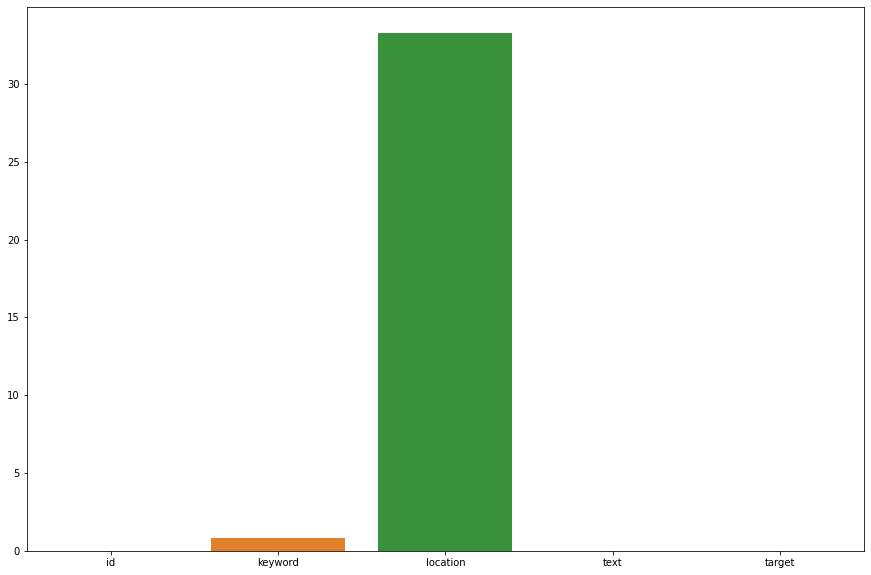

In [226]:
# checking the null value percentage in each column
plt.figure(figsize=(15,10))
sns.barplot(train_df.columns , train_df.isna().sum() / len(train_df) *100 )

In [227]:
# filling the null value with ' ' 

train_df['location'].fillna(' ' , inplace=True)
train_df['keyword'].fillna(' ' , inplace=True)

In [228]:
train_df.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [229]:
train_df.head(3)

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, ' 0:Fake  ,  1:Real disaster ')

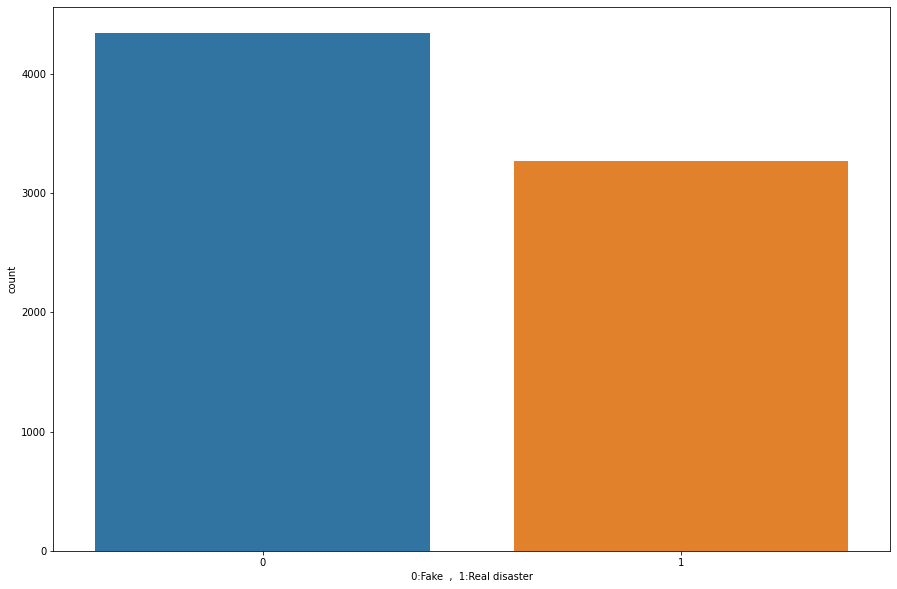

In [230]:
# Visualize target Column values count
plt.figure(figsize=(15,10))
sns.countplot(df['target'])
plt.xlabel(' 0:Fake  ,  1:Real disaster ')

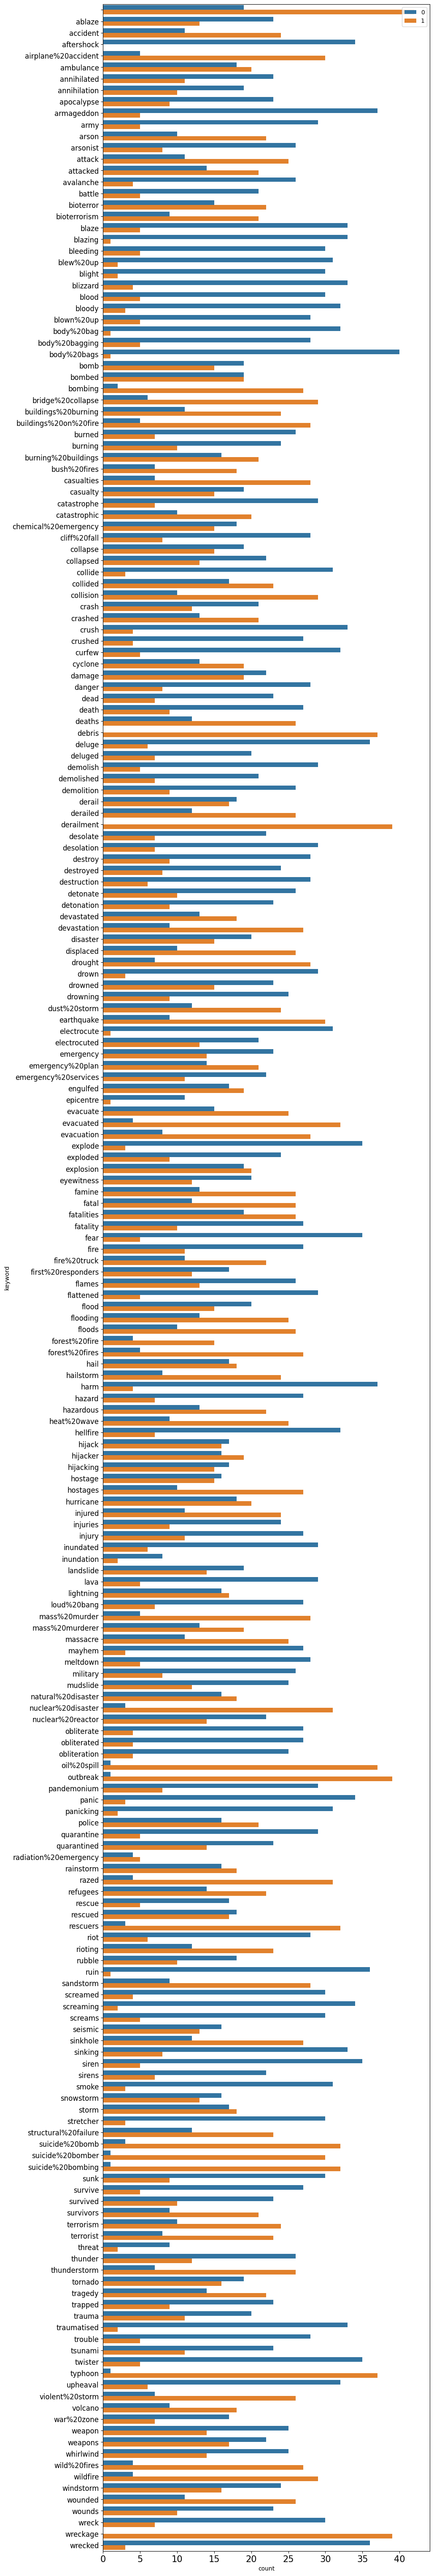

In [263]:
# Distribution of keywords in real and fake tweets 
plt.figure(figsize = (10, 80), dpi = 100)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
sns.countplot(y =train_df['keyword'], hue = train_df['target'])
plt.legend(loc='upper right')

##**Data Preprocessing**

In [253]:
 # create function to clean text 
 def text_preprocessing(s): 
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Substitute some non sense words 
    s = re.sub(r"\x89Û_", "", s)
    s = re.sub(r"\x89ÛÒ", "", s)
    s = re.sub(r"\x89ÛÓ", "", s)
    s = re.sub(r"\x89ÛÏWhen", "When",s)
    s = re.sub(r"\x89ÛÏ", "", s)
    s = re.sub(r"China\x89Ûªs", "China's", s)
    s = re.sub(r"let\x89Ûªs", "let's",s)
    s = re.sub(r"\x89Û÷", "", s)
    s = re.sub(r"\x89Ûª", "", s)
    s = re.sub(r"\x89Û\x9d", "", s)
    s = re.sub(r"å_", "", s)
    s = re.sub(r"\x89Û¢", "", s)
    s = re.sub(r"\x89Û¢åÊ", "", s)
    s = re.sub(r"fromåÊwounds", "from wounds",s)
    s = re.sub(r"åÊ", "", s)
    s = re.sub(r"åÈ", "", s)
    s = re.sub(r"JapÌ_n", "Japan", s)    
    s = re.sub(r"Ì©", "e", s)
    s = re.sub(r"å¨", "", s)
    s = re.sub(r"SuruÌ¤", "Suruc", s)
    s = re.sub(r"åÇ", "", s)
    s = re.sub(r"å£3million", "3 million", s)
    s = re.sub(r"åÀ", "", s)
    
    return s

In [232]:
# apply the function on the text feature
train_df['text']=train_df['text'].apply(text_preprocessing)

In [233]:
#inite the tfidf vectorizer

vec = TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS)



In [234]:
#split the Data to x , y

x =  vec.fit_transform(train_df['text'])

y = train_df['target']

# split data int train & test 

x_train , x_test , y_train , y_test = train_test_split(x,y , test_size=0.25 , random_state = 42)

In [235]:
x_train.shape ,  x_test.shape

((5709, 19318), (1904, 19318))

##**Data Modeling**

In [236]:
# iniate the RandomForestClassifier 

Rf_clf = RandomForestClassifier()

In [237]:
#Fit the data to the RandomForestClassifier

Rf_clf.fit(x_train,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [238]:
print("Test Accuracy  : {:.2f} %".format(accuracy_score(Rf_clf.predict(x_test),y_test)*100))

Test Accuracy  : 78.68 %


In [239]:
#intiate the LogisticRegression model and fit the data to it 

Log_clf = LogisticRegression()

Log_clf.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [240]:
print("Test Accuracy  : {:.2f} %".format(accuracy_score(Log_clf.predict(x_test),y_test)*100))

Test Accuracy  : 79.41 %


In [241]:
# try the Naive base model

Nv_clf = MultinomialNB()

Nv_clf.fit(x_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [242]:
print("Test Accuracy  : {:.2f} %".format(accuracy_score(Nv_clf.predict(x_test),y_test)*100))

Test Accuracy  : 79.52 %


##**XGboost hyper-parameters**

In [259]:
params = {'estimator__learning_rate' :[0.01, 0.1, 0.2],
          'estimator__n_estimators':[10,100,500],
          'estimator__subsample':(0.2,0.6,0.8),
          'estimator__max_depth':np.arange(1,6),
          'estimator__min_child_weight':np.arange(1,6)}
xgb = XGBClassifier()
xgb_clf = RandomizedSearchCV(estimator=xgb, param_distributions=params, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
xgb_clf.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'estimator__learning_rate': [0.01, 0.1,
                                      

In [261]:
print("Test Accuracy  : {:.2f} %".format(accuracy_score(xgb_clf.predict(x_test),y_test)*100))

Test Accuracy  : 72.37 %


##**Feature Engineering**

* try to merge location & keyword with the text in new column `tweet`

In [243]:
train_df['tweet'] = train_df['keyword'] + ' ' + train_df['location'] + ' ' + train_df['text']

train_df[20:500]

,id,keyword,location,text,target,tweet
20,31,,,this is ridiculous,0,this is ridiculous
21,32,,,london is cool,0,london is cool
22,33,,,love skiing,0,love skiing
23,34,,,what a wonderful day,0,what a wonderful day
24,36,,,looooool,0,looooool
...,...,...,...,...,...,...
495,717,attacked,London,christian attacked by muslims at the temple mo...,1,attacked London christian attacked by muslims ...
496,719,attacked,london / st catharines ?,tbt remember that time patrick kane attacked ...,0,attacked london / st catharines ? tbt remembe...
497,720,attacked,,im feeling attacked http t co 91jvyc...,0,attacked im feeling attacked http t ...
498,721,attacked,Peshawar,ik only troll his pol rivals never literally a...,0,attacked Peshawar ik only troll his pol rivals...


In [244]:
#inite the tfidf vectorizer

vec = TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS)

#split the Data to x , y using tweet as x

x =  vec.fit_transform(train_df['tweet'])

y = train_df['target']

# split data int train & test 

x_train , x_test , y_train , y_test = train_test_split(x,y , test_size=0.25 , random_state = 42)

In [245]:
# iniate the RandomForestClassifier 

Rf_clf = RandomForestClassifier()

#Fit the data to the RandomForestClassifier

Rf_clf.fit(x_train,y_train)

print("Test Accuracy  : {:.2f} %".format(accuracy_score(Rf_clf.predict(x_test),y_test)*100))

Test Accuracy  : 77.68 %


In [273]:
print (classification_report(y_test , Rf_clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.75      0.93      0.83      1091
           1       0.85      0.58      0.69       813

    accuracy                           0.78      1904
   macro avg       0.80      0.75      0.76      1904
weighted avg       0.79      0.78      0.77      1904



In [246]:
#intiate the LogisticRegression model and fit the data to it 

Log_clf = LogisticRegression()

Log_clf.fit(x_train,y_train)

print("Test Accuracy  : {:.2f} %".format(accuracy_score(Log_clf.predict(x_test),y_test)*100))


Test Accuracy  : 78.83 %


In [272]:
print (classification_report(y_test , Log_clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1091
           1       0.81      0.66      0.73       813

    accuracy                           0.79      1904
   macro avg       0.79      0.77      0.78      1904
weighted avg       0.79      0.79      0.78      1904



In [247]:
# try the Naive base model

Nv_clf = MultinomialNB()

Nv_clf.fit(x_train,y_train)

print("Test Accuracy  : {:.2f} %".format(accuracy_score(Nv_clf.predict(x_test),y_test)*100))

Test Accuracy  : 79.36 %


In [248]:
print (classification_report(y_test , Nv_clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1091
           1       0.81      0.67      0.73       813

    accuracy                           0.79      1904
   macro avg       0.80      0.78      0.78      1904
weighted avg       0.80      0.79      0.79      1904



##**Create the Submession file**

In [249]:
test_df = pd.read_csv(Test_path)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [250]:
test_df.shape

(3263, 4)

In [251]:
x = vec.transform(test_df['text'])

x.shape

(3263, 21168)

In [270]:
predictions = Log_clf.predict(x)

In [271]:
submission=pd.DataFrame()
submission['id']=test_df['id']
submission['target']=predictions

submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
